## Final Project Checkpoint

Analysing image reconstruction and generation using VAE and GANs

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

 ### I. Image Reconstruction using VAE

 Dataset used: MNIST

#### 1. Load MNIST Dataset

In [33]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

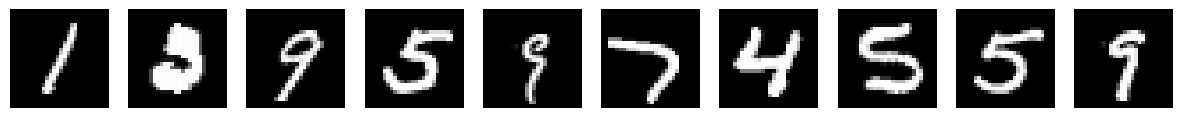

In [34]:
# Plot random samples 

data_batch, _ = next(iter(train_loader))  # Get the first batch

num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3)) 

for i in range(num_samples):
    img = data_batch[i].squeeze().numpy()  # Get the image, remove the channel dimension, and convert to numpy
    axes[i].imshow(img, cmap='gray')  
    axes[i].axis('off') 

plt.show()

Let's invert these images for better visualization

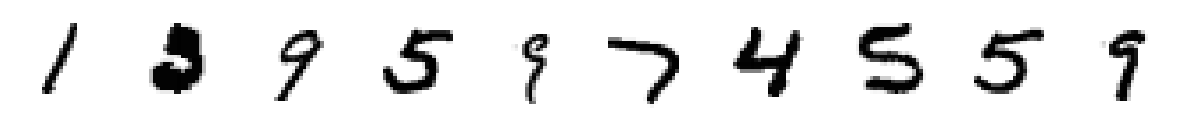

In [35]:
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3)) 
for i in range(num_samples):
    img = (1 - data_batch[i]).squeeze().numpy()  # Get the image, remove the channel dimension, and convert to numpy
    axes[i].imshow(img, cmap='gray')  
    axes[i].axis('off') 

plt.show()

In [36]:
# Define an inversion transform
class InvertData(object):
    def __call__(self, tensor):
        return 1 - tensor

In [37]:
# Invert the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    InvertData()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() 
                      else "cpu")
print(device)

mps


In [39]:
# MNIST dataset are single channel 28x28 handwritten numerical digits
data_batch[i].shape

torch.Size([1, 28, 28])

#### 2. Define the Variational Autoencoder architecture 

In [40]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )

        self.mu = nn.Linear(256, latent_dim) # Mean
        self.logvar = nn.Linear(256, latent_dim) # Log Variance of Gaussian Distrubution

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), # 14x14 -> 28x28
            nn.Sigmoid() # Output pixels between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    # Since for backpropagation latent sampling is not differenciable in case of VAE
    # So we are using reparameterization trick to makle it differenciable
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum') # Calculate MSE
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # Calculate KL Divergence loss
    return BCE + KLD

#### 3. Initialize the model and hyperparameters

In [41]:
batch_size = 64
latent_dim = 20 
epochs = 100
learning_rate = 0.0005

model_vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=learning_rate)

#### 4. Training loop

In [42]:
model_vae.train()
losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model_vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    losses.append(total_loss)

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 158.36605034179686
Epoch 2, Loss: 114.88015225423177
Epoch 3, Loss: 107.96093712565104
Epoch 4, Loss: 105.07346353759766
Epoch 5, Loss: 103.34864739583334
Epoch 6, Loss: 102.1833003499349
Epoch 7, Loss: 101.25808107910156
Epoch 8, Loss: 100.48541638183593
Epoch 9, Loss: 99.89179979654948
Epoch 10, Loss: 99.3905111735026
Epoch 11, Loss: 99.0323309407552
Epoch 12, Loss: 98.61085735677084
Epoch 13, Loss: 98.25747755126953
Epoch 14, Loss: 98.02910694173177
Epoch 15, Loss: 97.69175076497396
Epoch 16, Loss: 97.46766169840495
Epoch 17, Loss: 97.2521400390625
Epoch 18, Loss: 97.03208176676432
Epoch 19, Loss: 96.87513012695312
Epoch 20, Loss: 96.69617320963542
Epoch 21, Loss: 96.54564302571615
Epoch 22, Loss: 96.35976717122396
Epoch 23, Loss: 96.21847598470052
Epoch 24, Loss: 96.08649149576823
Epoch 25, Loss: 96.00173622639974
Epoch 26, Loss: 95.86089419759115
Epoch 27, Loss: 95.7945600789388
Epoch 28, Loss: 95.67860895182292
Epoch 29, Loss: 95.57743143717448
Epoch 30, Loss: 95.4

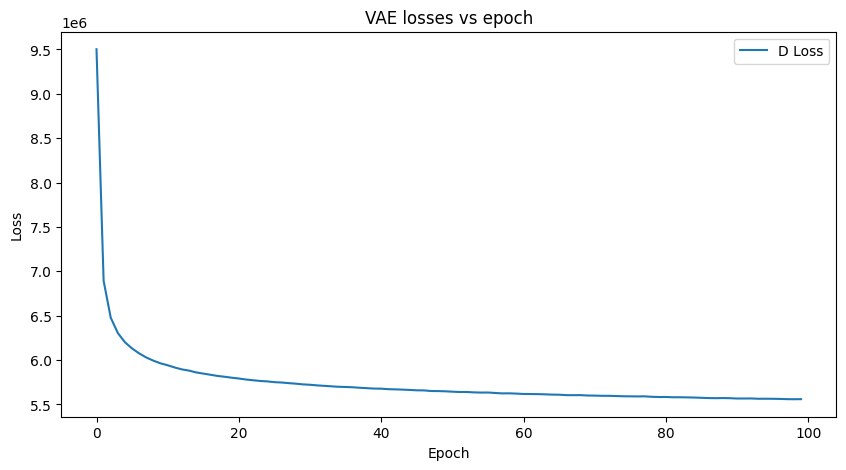

In [43]:
plt.figure(figsize=(10,5))
plt.title("VAE losses vs epoch")
plt.plot(losses, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### 5. Image generation from Latent space

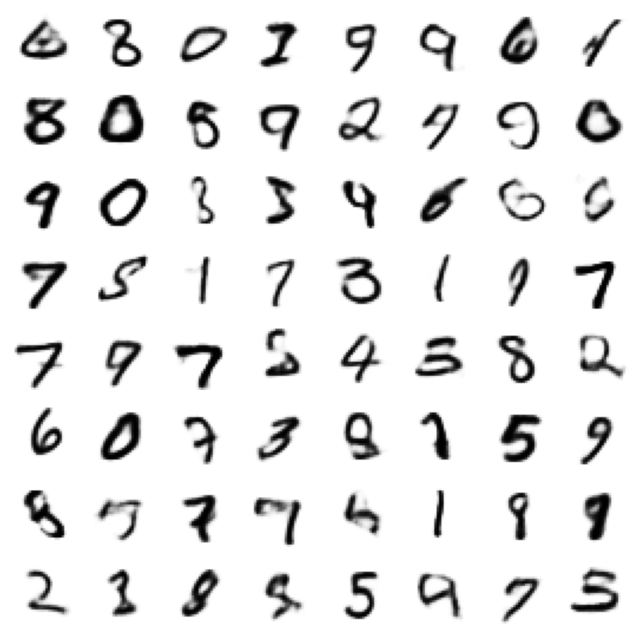

In [44]:
model_vae.eval() 
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device) # Sample latent vectors
    generated_images = model_vae.decode(z).cpu()

# Visualize generated images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

It is observed that the reconstructed images are blurred. Now let's compare some random and reconstructed images from test set.

#### 6. Visualize reconstructions of test data

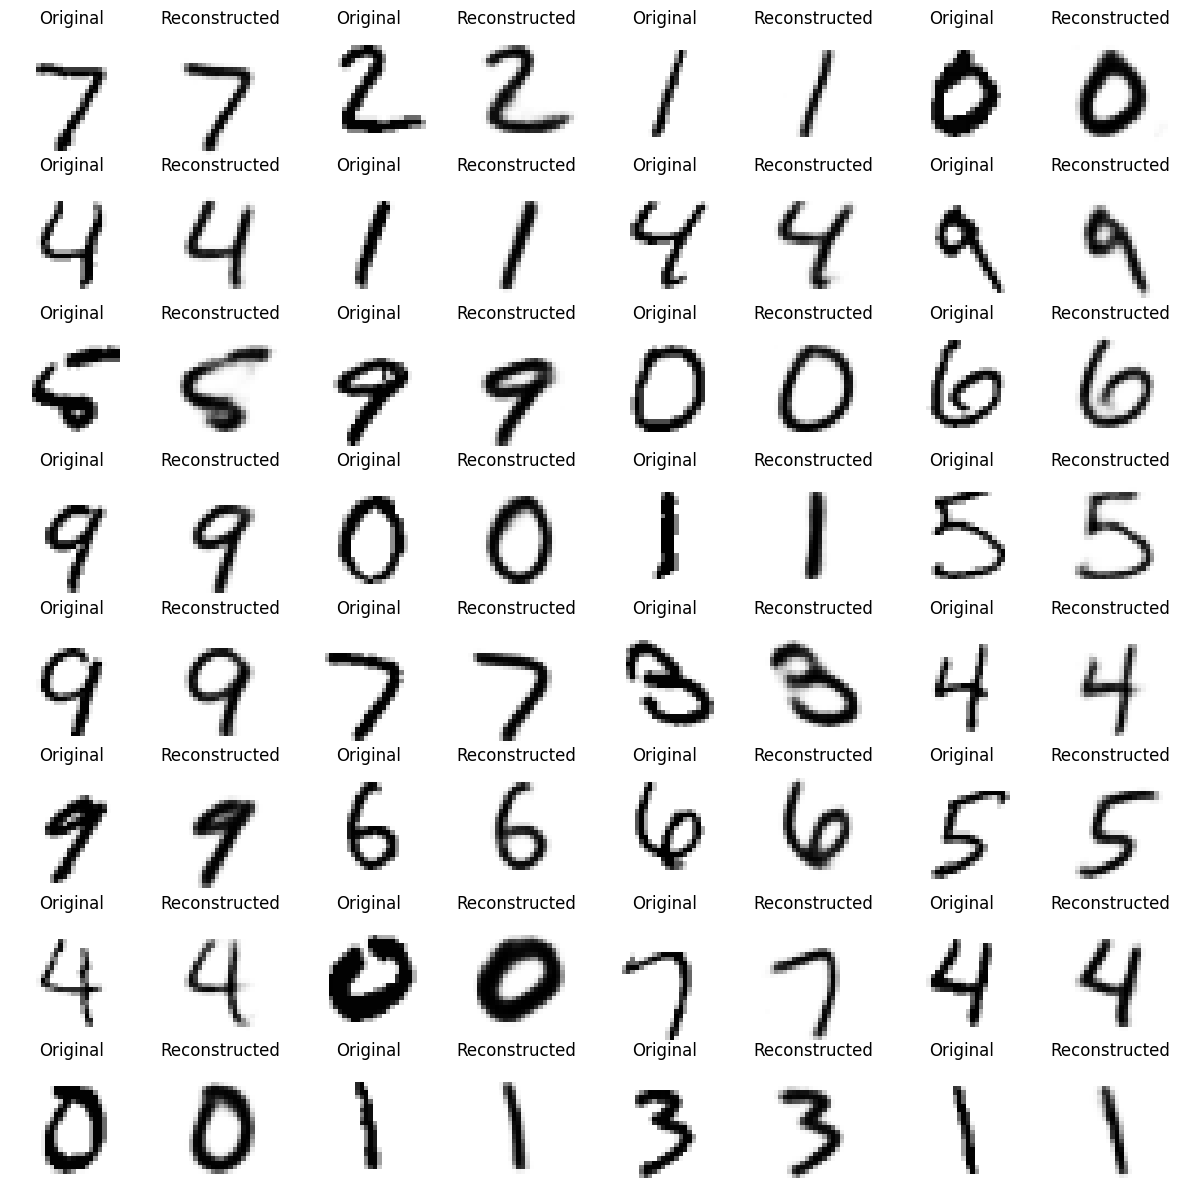

In [45]:
data_test, _ = next(iter(test_loader))
data_test = data_test.to(device)

model_vae.eval()
with torch.no_grad():
  reconstructed_test, _, _ = model_vae(data_test)

fig, axes = plt.subplots(8, 8, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < 64:
      if i % 2 == 0:
        ax.imshow(data_test[i//2].cpu().squeeze(), cmap='gray')
        ax.set_title("Original")
      else:
        ax.imshow(reconstructed_test[(i-1)//2].cpu().squeeze(), cmap='gray')
        ax.set_title("Reconstructed")
    ax.axis('off')
plt.show()

#### Interesting results and observations

- VAE reconstucts blurry images because they learn probability latent distribution of image features rather than precise pixel values. So sampling from these latent representation produces average (mean) values of their latent distribution, resulting in blurred image.

![VAE reconstruced '0'](results/vae_reconstructed_1.png)

- In the above reconstructed letter '0' the VAE model is able to reconstruct a perfect zero, despite having a cut in the original image.

![VAE reconstruced '3 or 8'](results/vae_reconstructed_2.png)
- In the above image, the reconstructed image looks like a mixture of letter 3 and 8. This is because the latent representation distribution of original image lies somewhere between 3 and 8. So VAE reproduces this image which includes distributions of both the letters.


In [46]:
# Save model weights
torch.save(model_vae.state_dict(), 'vae_model_weights.pth')

### II. Image Generation using GANs

Dataset used: CIFAR-10

#### 1. Define Hyperparameters

In [ ]:
batch_size = 64
num_epochs = 200
learning_rate = 0.0002
beta1 = 0.5
z_dim = 100
image_size = 32
channels_img = 3

g_features = 64
d_features = 64

seed = 42
torch.manual_seed(seed)

os.makedirs("generated_images", exist_ok=True)

#### 2. Load Dataset

In [53]:
transform_gan = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_gan = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_gan
)

dataloader_gan = DataLoader(
    train_dataset_gan,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

print(f"Number of training images: {len(train_dataset_gan)}")
print(f"Number of batches per epoch: {len(dataloader_gan)}")


Files already downloaded and verified
Number of training images: 50000
Number of batches per epoch: 782


#### 3. Define GAN model

In [56]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, g_feats=64, out_channels=3):
        super().__init__()
        self.net = nn.Sequential(

            spectral_norm(nn.ConvTranspose2d(z_dim, g_feats*8, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(g_feats*8),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(g_feats*8, g_feats*4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(g_feats*4),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(g_feats*4, g_feats*2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(g_feats*2),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(g_feats*2, g_feats, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(g_feats),
            nn.ReLU(True),

            spectral_norm(nn.ConvTranspose2d(g_feats, out_channels, 3, 1, 1, bias=False)),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, d_feats=64):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, d_feats, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(d_feats, d_feats*2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(d_feats*2, d_feats*4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(d_feats*4, d_feats*8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(d_feats*8, 1, 2, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

G = Generator(z_dim, g_features, channels_img).to(device)
D = Discriminator(channels_img, d_features).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

print(G)
print(D)


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
D

#### 4. Train GAN model

In [57]:

def train_gan(G, D, dataloader, num_epochs, z_dim, device):
    real_label_val = 0.9

    criterion = nn.BCELoss()

    optimizerG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
    optimizerD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    d_losses = []
    g_losses = []

    fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

    G.train()
    D.train()

    for epoch in range(num_epochs):
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (real_imgs, _) in pbar:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            D.zero_grad()
            real_labels = torch.full((batch_size,), real_label_val, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            out_real = D(real_imgs).view(-1)
            d_loss_real = criterion(out_real, real_labels)

            noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(noise)
            out_fake = D(fake_imgs.detach()).view(-1)
            d_loss_fake = criterion(out_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizerD.step()

            G.zero_grad()
            out_fake_for_G = D(fake_imgs).view(-1)
            g_loss = criterion(out_fake_for_G, real_labels)
            g_loss.backward()
            optimizerG.step()

            pbar.set_description(
                f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}"
            )

        if (epoch+1) % 50 == 0:
            with torch.no_grad():
                fake_samples = G(fixed_noise).cpu()
            grid = make_grid(fake_samples, nrow=8, normalize=True, value_range=(-1,1))
            np_grid = grid.numpy().transpose((1,2,0))
            plt.figure(figsize=(6,6))
            plt.imshow(np_grid)
            plt.title(f"Epoch {epoch+1}")
            plt.axis("off")
            plt.show()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())


    plt.figure(figsize=(10,5))
    plt.title("Discriminator and Generator Losses")
    plt.plot(d_losses, label="D Loss")
    plt.plot(g_losses, label="G Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    torch.save(G.state_dict(), "generator.pth")
    torch.save(D.state_dict(), "discriminator.pth")
    print("Training Complete")

Epoch [50/200] D Loss: 1.3797, G Loss: 0.7091: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s]


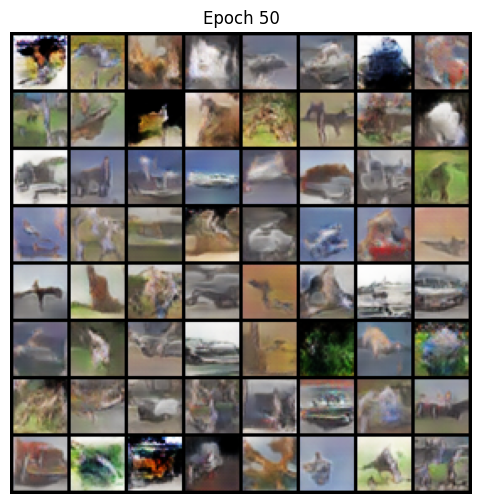

Epoch [100/200] D Loss: 1.3623, G Loss: 0.7102: 100%|██████████| 782/782 [01:02<00:00, 12.46it/s]


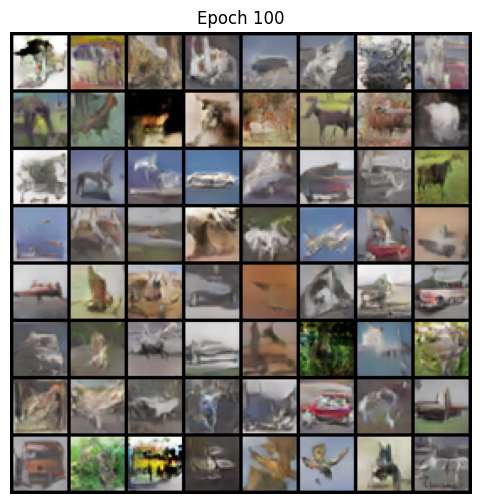

Epoch [150/200] D Loss: 1.3760, G Loss: 0.7236: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s]


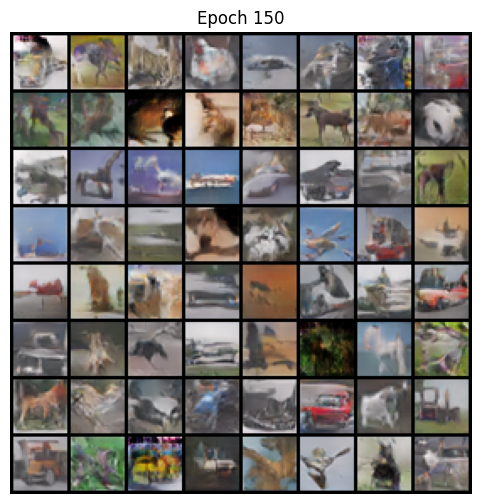

Epoch [200/200] D Loss: 1.2959, G Loss: 0.7512: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s]


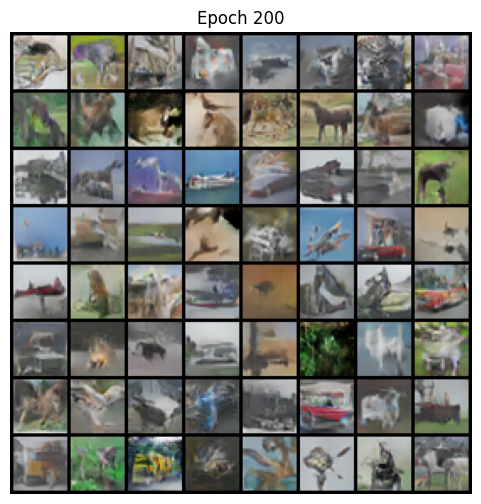

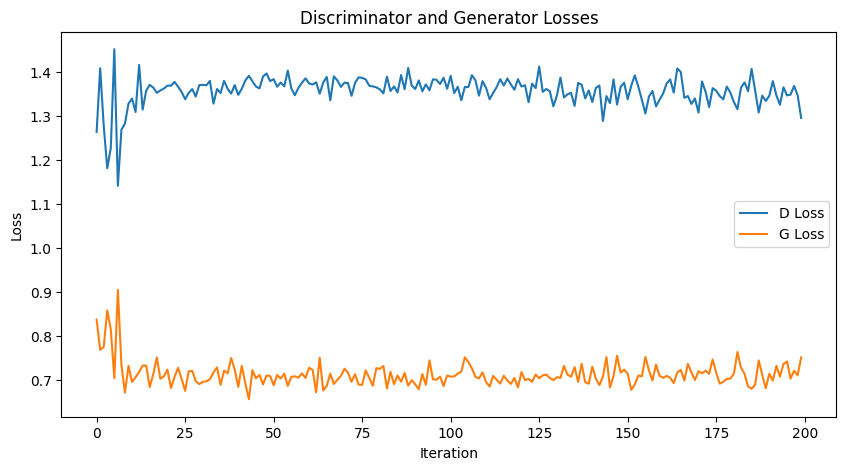

Training Complete


In [58]:
train_gan(G, D, dataloader_gan, num_epochs=200, z_dim=100, device=device)


#### 5. Generate some sample images using fixed random noise

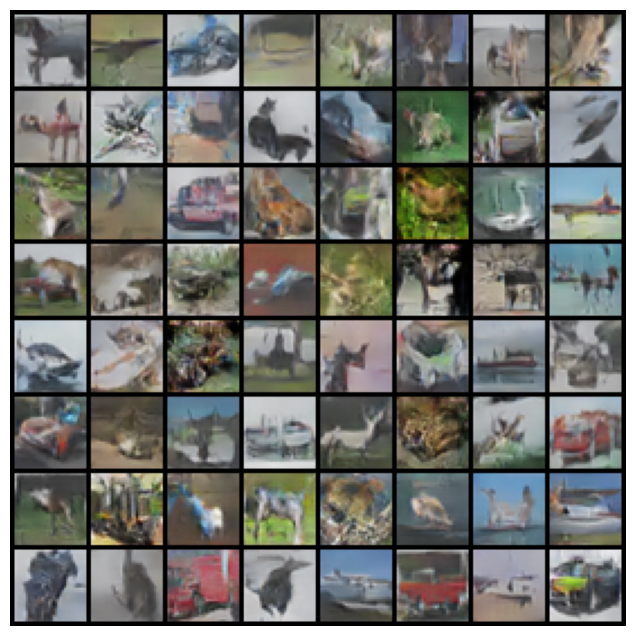

In [59]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
with torch.no_grad():
    fake_samples = G(fixed_noise).cpu()

grid = make_grid(fake_samples, nrow=8, normalize=True, value_range=(-1,1))

fake_samples = 0.5 * fake_samples + 0.5
grid = make_grid(fake_samples, nrow=8)

np_grid = grid.numpy().transpose((1,2,0))
plt.figure(figsize=(8,8))
plt.imshow(np_grid)
plt.axis("off")
plt.show()